In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

### Data processing

In [6]:

base_dir = os.path.join(os.getcwd(), "Data/cats_dogs_filtered/")

training_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")

# Get the tf.data.datasets
training_dataset = tf.keras.utils.image_dataset_from_directory(training_dir,
                                                               image_size=(150,150), 
                                                               batch_size=20,
                                                               label_mode='binary')

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir, 
                                                                image_size=(150,150), 
                                                                batch_size=20,
                                                                label_mode='binary')

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.



#### Preprocessing data in pre-trained models

<br>

- When using pretrained models, you should make it a habit to check the documentation for any preprocessing steps. In this case, the [InceptionV3 documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/InceptionV3) says that the inputs should be scaled to the range [-1,1].
- It has a [`preprocess_input()`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input)  method that you can use to rescale the inputs. The cell below defines a `preprocess` function that uses this method, which you can then map to the datasets.

In [7]:

# Preprocess the input data
def preprocess_map_func(image, label):
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, label

# Apply the preprocessing function to every element in the dataset
training_dataset_scaled = training_dataset.map(preprocess_map_func)
validation_dataset_scaled = validation_dataset.map(preprocess_map_func)

In [8]:

# Augmentation
training_dataset_final = training_dataset_scaled.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
validation_dataset_final = validation_dataset_scaled.cache().prefetch(tf.data.AUTOTUNE)

### Load pre-trained model

In [2]:
# Load the required files
local_weight_file = os.path.join(os.getcwd(), "Data/inception_v3_weights.h5")

# Get the inceptionv3 architecture from Keras
inception_pretrained_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=(150,150,3),
                                                                           include_top=False,
                                                                           weights=None)
# Load the custom weights from the h5 file
inception_pretrained_model.load_weights(local_weight_file)

# Freeze layers in the pretrained model
for layer in inception_pretrained_model.layers:
    layer.trainable = False

2025-06-26 20:05:51.504895: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-06-26 20:05:51.505051: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-26 20:05:51.505056: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1750948551.505522 16493943 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1750948551.505567 16493943 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
inception_pretrained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [4]:
# Choose the last layer for the pre-trained model
last_layer = inception_pretrained_model.get_layer('mixed7')
print(f"Last layer output shape: {last_layer.output.shape}")

last_layer_output = last_layer.output

Last layer output shape: (None, 7, 7, 768)


### Add custom layers to the model

In [5]:
# Custom layers
x = tf.keras.layers.Flatten()(last_layer_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Append the custom layers to the pre-trained model
model = tf.keras.Model(inception_pretrained_model.input, x)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 47,512,481 (181.25 MB)

 Trainable params: 38,537,217 (147.01 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

### Prepare the final model

In [9]:
augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.4),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
    tf.keras.layers.RandomContrast(0.4),
    tf.keras.layers.RandomZoom(0.2),
])

inputs = tf.keras.Input(shape=(150,150,3))
x = augmentation_layers(inputs)
x = model(x)

final_model = tf.keras.Model(inputs, x)

In [10]:
tf.keras.utils.plot_model(final_model, to_file="final_tl_model.png" , show_shapes=True, show_layer_names=True, expand_nested=True)

In [11]:
final_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [12]:
# Train the model

history = final_model.fit(training_dataset_final,
                          validation_data=validation_dataset_final,
                          epochs=30)

Epoch 1/30


2025-06-26 20:10:23.854037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 0.5457 - loss: 3.0324 - val_accuracy: 0.9210 - val_loss: 0.2645
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.6457 - loss: 2.5161 - val_accuracy: 0.9510 - val_loss: 0.1745
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - accuracy: 0.6532 - loss: 2.4018 - val_accuracy: 0.6920 - val_loss: 3.2009
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.6385 - loss: 3.2698 - val_accuracy: 0.9410 - val_loss: 0.2810
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.7013 - loss: 2.0371 - val_accuracy: 0.9400 - val_loss: 0.3318
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.6705 - loss: 2.5360 - val_accuracy: 0.9430 - val_loss: 0.2736
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.6812 - loss: 2.0493 - val_accuracy: 0.9250 - val_loss: 0.3843
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.6947 - loss: 2.2211 - val

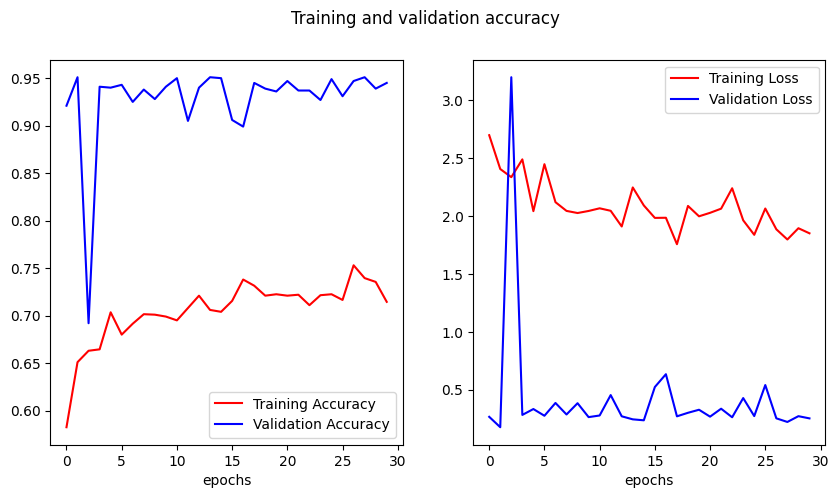

In [13]:
# Plot the results
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()